In [1]:
import sys
import os
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(script_dir)
sys.path.insert(0, parent_dir)

import functions
import models
import gradcam
import pickle
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Use the GPU instead of the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the label maps
dataset_path = '/mnt/ssd/dataset/scardovi/genimage256'
dataset_path = '/home/scardovi/genimage256'

with open(os.path.join(dataset_path, 'imagenet_classes.txt'), 'r') as file:
    labels = [line.strip() for line in file.readlines()]
multiclass_labels_map = {index: label for index, label in enumerate(labels)}

# Compose the transform that will be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# training
train_ds = functions.MulticlassGenImage(img_dir=dataset_path, transform=transform)

# validation and testing
val_ground_truth = functions.val_mapping(dataset_path)
val_test_ds= functions.MulticlassGenImage(img_dir=dataset_path, val_gt=val_ground_truth, transform=transform)
# Perform a stratified split
stratify_labels = [f"{label['generator']}{label['multiclass']}" for label in val_test_ds.img_labels]
idx_val, idx_test = train_test_split(
    range(len(val_test_ds)),
    test_size=0.5,  # 50-50 split
    random_state=0
)
validation_ds = Subset(val_test_ds, idx_val)
test_ds = Subset(val_test_ds, idx_test)

cuda


model_init_function = models.multiclass_finetuning
epochs = 5
batch_size = 64
lr = 0.0001
val_batch_size = 64


val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['generator'])}"

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '_short.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '_short.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

# Model training

model_init_function = models.multiclass_finetuning
epochs = 60
batch_size = 64
lr = 0.1
val_batch_size = 64
scheduler_patience=7

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_complete_batch{batch_size}"
print("\n\n - " + model_name)
writer = SummaryWriter('logs/'+model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl, writer=writer, scheduler_patience=scheduler_patience)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['generator'])}"
writer.close()

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)



 - multiclass_finetuning_complete_pt2_batch64
- Epoch 1: current lr = 1e-05
Train error: Combined=6.52%; Multiclass=6.23%; Generator=0.29%; 
Validation error: Combined=34.36%;  Multiclass=30.33%; Generator=4.70%; 
Train loss: 3.235e-01; Val loss: 1.661e+00
- Epoch 2: current lr = 1e-05
Train error: Combined=6.38%; Multiclass=6.10%; Generator=0.28%; 
Validation error: Combined=34.45%;  Multiclass=30.35%; Generator=4.77%; 
Train loss: 3.209e-01; Val loss: 1.672e+00
- Epoch 3: current lr = 1e-05
Train error: Combined=6.46%; Multiclass=6.18%; Generator=0.29%; 
Validation error: Combined=34.51%;  Multiclass=30.33%; Generator=4.85%; 
Train loss: 3.188e-01; Val loss: 1.659e+00
- Epoch 4: current lr = 1e-05
Train error: Combined=6.22%; Multiclass=5.97%; Generator=0.25%; 
Validation error: Combined=34.20%;  Multiclass=30.29%; Generator=4.57%; 
Train loss: 3.166e-01; Val loss: 1.673e+00
- Epoch 5: current lr = 1e-05
Train error: Combined=6.36%; Multiclass=6.12%; Generator=0.24%; 
Validation er

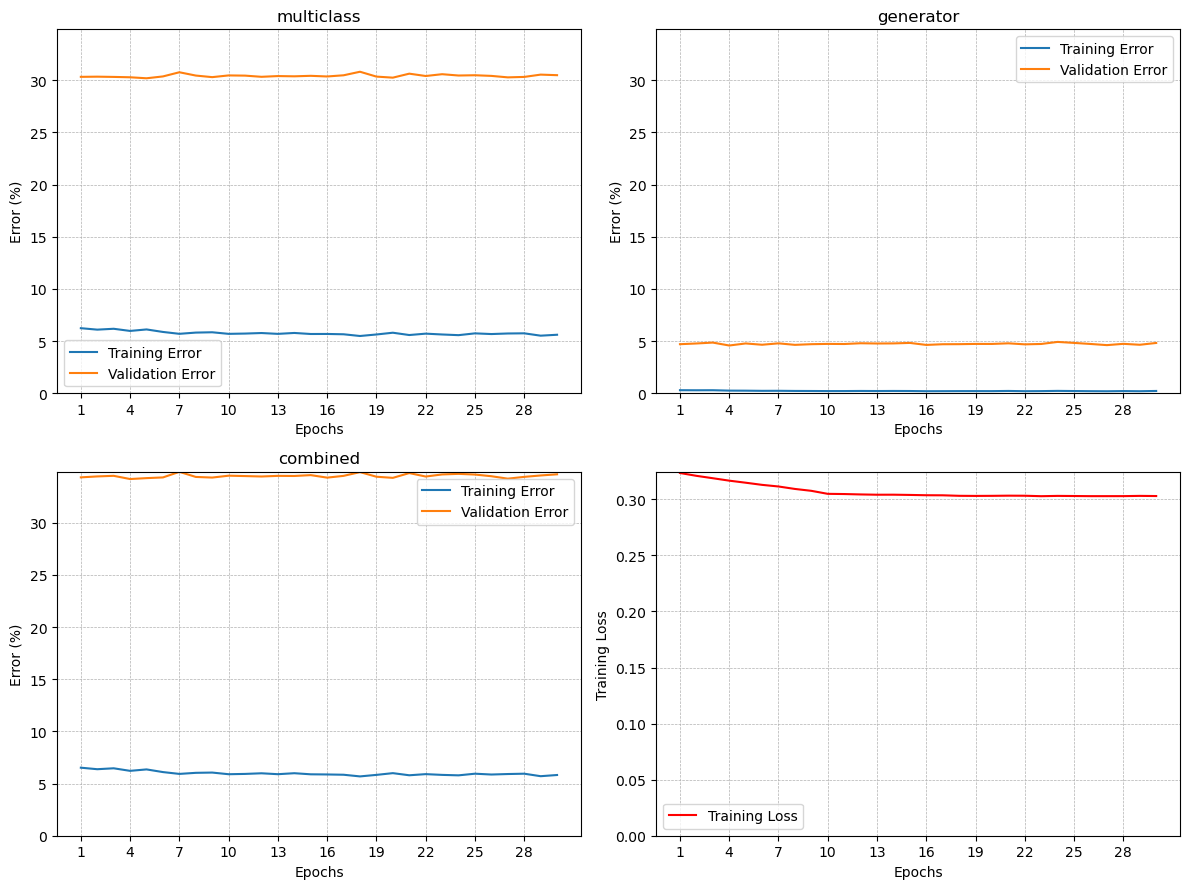

In [3]:
model_init_function = models.multiclass_finetuning
epochs = 30
batch_size = 64
lr = 0.00001
val_batch_size = 64
scheduler_patience=7

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model.load_state_dict(torch.load('./weights/multiclass_finetuning_complete_batch64_epochs60.pth'))
model = model.to(device)
model_name = f"{model_init_function.__name__}_complete_pt2_batch{batch_size}"
print("\n\n - " + model_name)
writer = SummaryWriter('logs/'+model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl, writer=writer, scheduler_patience=scheduler_patience)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['generator'])}"
writer.close()

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

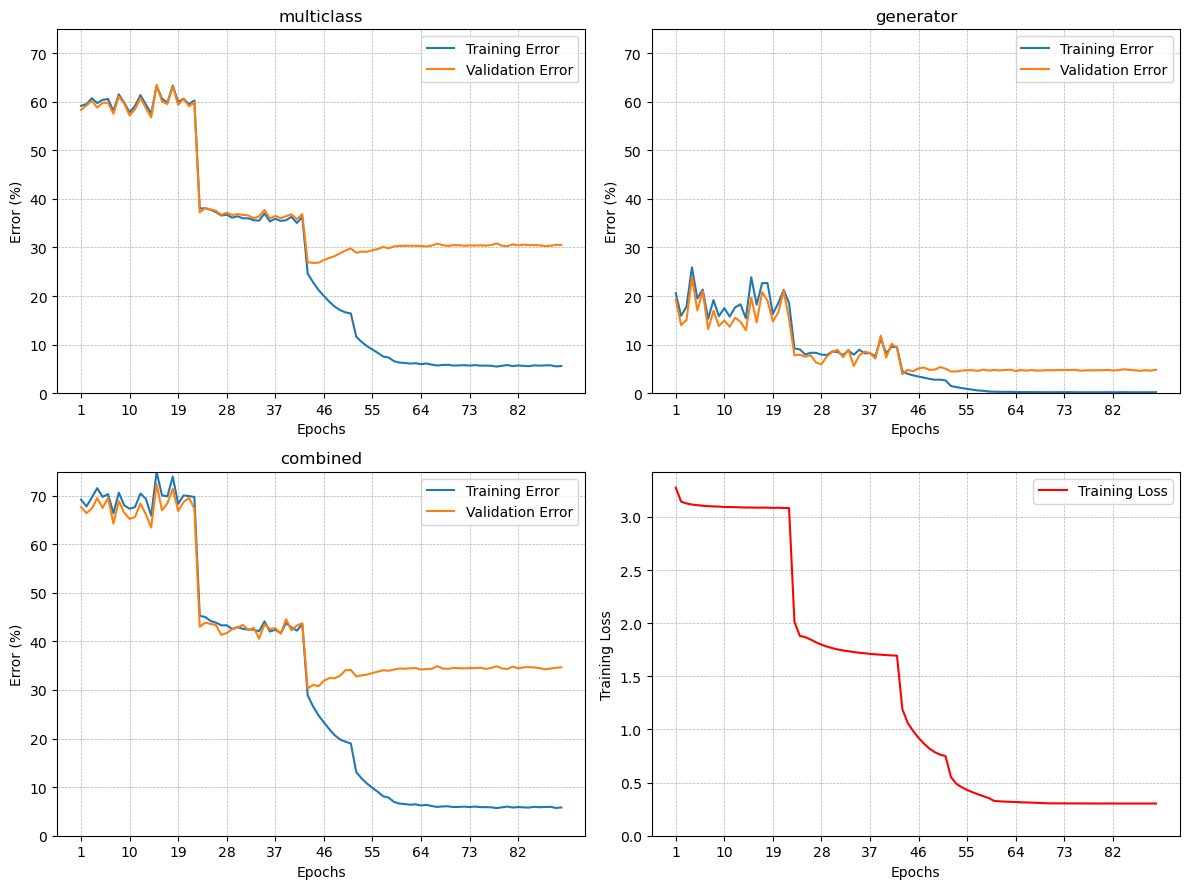

In [10]:
f = open("./stats/multiclass_finetuning_complete_batch64_epochs60.pkl", 'rb')
data = pickle.load(f)
f.close()
train_errors = data['train_errors']
val_errors = data['val_errors']
train_loss = data['train_loss']

f = open("./stats/multiclass_finetuning_complete_pt2_batch64_epochs30.pkl", 'rb')
data = pickle.load(f)
f.close()
for k in train_errors:
    train_errors[k] += data['train_errors'][k]
    val_errors[k] += data['val_errors'][k]
train_loss += data['train_loss']

functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)